In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
from scipy import interp
from scipy.sparse import hstack, csr_matrix

import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")

# CTRL + SHIFT + P => Run Code 
import sys
print('Python', sys.version)
print(sklearn.__version__)

Python 3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]
0.20.3


### Results Collection

In [2]:
global ResultsCollection 
ResultsCollection = pd.DataFrame(columns=('Algorithm', 'FeatureSet', 'TestAcc', 'TestAUC'))

global testSize
testSize = 0.25

# Create Folder to save too

from datetime import datetime
import os

date = datetime.now().strftime("%Y%m%d-%H%M%S") + " CV\\"

global path
path = "D:\\0_MyFiles\\0_Libraries\\Documents\\Education\\University\\Year 3\\FYP_Git\\Results\\" + str(date)

import os
if not os.path.exists(path):
    os.makedirs(path)

# Feature Set List

In [3]:
# Switch for multiple feautre sets
def getFeatureSet(number):
    return {
        3 : ['followers_count', 'friends_count', 'statuses_count', 'favourites_count', 'listed_count', 'verified', 
             'name_binary', 'screen_name_binary'],        
        99 : ['followers_count', 'friends_count', 'statuses_count', 'favourites_count', 'listed_count', 'verified', 
              'name', 'screen_name', 'description', 'bot'],
    }[number]

# Import Training Data

In [4]:
# Read training data from csv
training_data = pd.read_csv('training_data.csv')
t2 = pd.read_csv('genuine_accounts_users.csv')
t3 = pd.read_csv('fake_followers_users.csv')
training_data['description'].fillna(' ', inplace=True)

features = getFeatureSet(99)

t2['bot'] = 0
t3['bot'] = 1

t2 = t2[features]
t3 = t3[features]
training_data = training_data[features]

new_data = t2.append(t3, ignore_index=True)
training_data = new_data.append(training_data, ignore_index=True)

training_data = training_data.sample(frac=1).reset_index(drop=True)
training_data['description'].fillna(' ', inplace=True)
training_data['verified'].fillna('0', inplace=True)

# Feature Development

### Stemming applied to description

In [5]:
def getTextDesc(desc):
    try:
        if isinstance(desc, float):
            return ''
        return desc
    except Exception as error:
        return ''
    
training_data['description'] = training_data.apply(lambda row: getTextDesc(row['description']), axis=1)

def stemLine(sentence):
    stemmer = nltk.PorterStemmer()
    translator=sentence.translate(str.maketrans("","", string.punctuation))
    translator = translator.lower()
    tokens = word_tokenize(translator)
    final = [stemmer.stem(tagged_word) for tagged_word in tokens]
    return " ".join(final)

training_data['descriptionStemmed'] = training_data['description'].apply(lambda row: stemLine(row))

### Binary True/False Conditions

In [6]:
#Binary
name_keywords = r'bot|b0t|papers'
stemmedKeywords = r'bot|b0t|random|#botally|creat|thi|time|//|botal|pubm|made|im|gener|day|everi|paper|follow|tweet|word'
keywords = r'bot|b0t|papers|#botally|follow|every|made|//|random|day|daily|tweet|tweets|made'

training_data['name_binary'] = training_data.name.str.contains(keywords, case=False, na=False)
training_data['screen_name_binary'] = training_data.screen_name.str.contains(keywords, case=False, na=False)

training_data['description_binarySTEM'] = training_data.description.str.contains(stemmedKeywords, case=False, na=False)

training_data['description_binary'] = training_data.description.str.contains(keywords, case=False, na=False)
#training_data['status_binary'] = training_data.status.str.contains(keywords, case=False, na=False)

training_data['listed_count_binary'] = (training_data.listed_count>20000)==False

### TFIDF

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse as sparse

features = getFeatureSet(3)

vectorizer = CountVectorizer()
CountVec = vectorizer.fit_transform(training_data.descriptionStemmed.values.astype('U'))

CountVec = CountVec.toarray()

x = hstack([CountVec, csr_matrix(training_data[features].astype(int))])
x = x.tocsr()
y = training_data.bot

# Global Classifier Functions

In [8]:
from operator import itemgetter

# Calculate and print a classifiers accuracy
def testClassifer(classifier, x, y, printRoc, runName, feauteSet):
    predicted = cross_val_predict(classifier, x, y, cv=10)
    acc = metrics.accuracy_score(y, predicted)
    
    if printRoc == True:
        kf = KFold(n_splits=10)
                
        tprs = []
        base_fpr = np.linspace(0, 1, 101)
        plt.figure(figsize=(5, 5))
        
        for train_index, test_index in kf.split(x):  
            #X_train, X_test = x[train_index[0]:train_index[-1]+1], x[test_index[0]:test_index[-1]+1]
            X_train = itemgetter(train_index)(x)
            X_test = itemgetter(test_index)(x)

            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            model = classifier.fit(X_train, y_train)
            y_score = model.predict_proba(X_test)
            fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])

            plt.plot(fpr, tpr, 'b', alpha=0.15)
            tpr = interp(base_fpr, fpr, tpr)
            tpr[0] = 0.0
            tprs.append(tpr)
            
        tprs = np.array(tprs)
        mean_tprs = tprs.mean(axis=0)
        std = tprs.std(axis=0)

        mean_tprs[-1] = 1.0
        mean_auc = auc(base_fpr, mean_tprs)
        
        tprs_upper = np.minimum(mean_tprs + std, 1)
        tprs_lower = mean_tprs - std
        
        plt.plot(base_fpr, mean_tprs, 'b', label=r'Mean ROC AUC = %0.2f' % (mean_auc))
        plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
        
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.axes().set_aspect('equal', 'datalim')
        plt.title(str(feauteSet) + " " + runName + " ROC Curve")
        plt.legend(loc = 'lower right')
        plt.savefig(path + str(feauteSet) + ' ' + runName + '.png')
        plt.show()
        
    print('Accuracy:  ', acc)
    print('AUC:  ', mean_auc)
    
    return acc, mean_auc

# Classifiers

### Naive Bayes

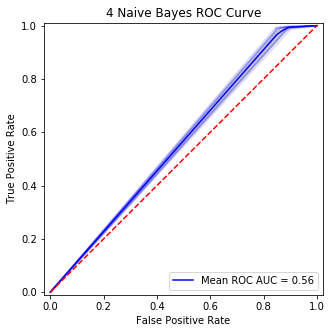

Accuracy:   0.546352109748493
AUC:   0.5596161808589192


In [9]:
# Run Naive Bayes 
def run_NB(feauteSet, printRoc, runName):
    nb = MultinomialNB(alpha=0.00000000001)
    acc, mean_auc = testClassifer(nb, x, y, printRoc, runName, feauteSet)
    return pd.Series([runName, feauteSet, acc, mean_auc], 
                      index=['Algorithm','FeatureSet','TestAcc','TestAUC'])

ResultsCollection = ResultsCollection.append(run_NB(4, True, 'Naive Bayes'), ignore_index=True)

### Logistic Regression

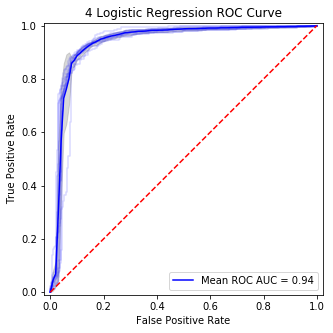

Accuracy:   0.8740386614009561
AUC:   0.936735943267654


In [10]:
# Run Logistic Regression
def run_LR(feauteSet, printRoc, runName):
    lr = LogisticRegression(random_state=10, solver='lbfgs',multi_class='multinomial', C=0.00001)
    
    acc, mean_auc = testClassifer(lr, x, y, printRoc, runName, feauteSet)
    return pd.Series([runName, feauteSet, acc, mean_auc], 
                      index=['Algorithm','FeatureSet','TestAcc','TestAUC'])

ResultsCollection = ResultsCollection.append(run_LR(4, True, 'Logistic Regression'), ignore_index=True)

### Support Vector Machine

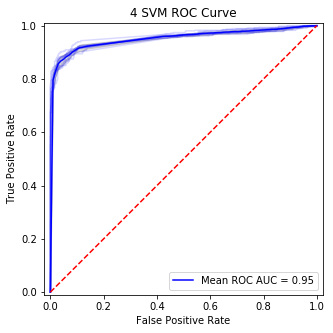

Accuracy:   0.9152982747869466
AUC:   0.9506122342495136


In [11]:
# Run Support Vector Machine 
def run_SVM(feauteSet, printRoc, runName):
    sv = svm.SVC(gamma='auto', probability=True, C=10)
    
    acc, mean_auc = testClassifer(sv, x, y, printRoc, runName, feauteSet)
    return pd.Series([runName, feauteSet, acc, mean_auc], 
                      index=['Algorithm','FeatureSet','TestAcc','TestAUC'])

ResultsCollection = ResultsCollection.append(run_SVM(4, True, 'SVM'), ignore_index=True)

### Decision Tree 

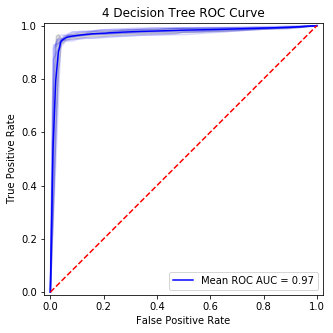

Accuracy:   0.9510496778216587
AUC:   0.9695832262258146


In [12]:
# Run Decision Tree
def run_DT(feauteSet, printRoc, runName):
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2, max_depth=10)

    acc, mean_auc = testClassifer(dt, x, y, printRoc, runName, feauteSet)
    return pd.Series([runName, feauteSet, acc, mean_auc], 
                      index=['Algorithm','FeatureSet','TestAcc','TestAUC'])

ResultsCollection = ResultsCollection.append(run_DT(4, True, 'Decision Tree'), ignore_index=True)

### Random Forest

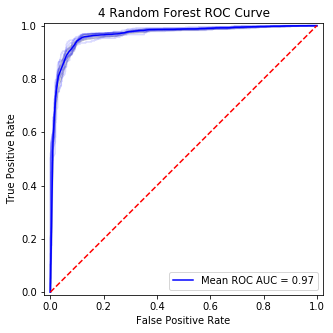

Accuracy:   0.9136354188318437
AUC:   0.9664257589133516


In [13]:
# Run Random Forest 
def run_RF(feauteSet, printRoc, runName):
    rf = RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=1, n_estimators=1000)

    acc, mean_auc = testClassifer(rf, x, y, printRoc, runName, feauteSet)
    return pd.Series([runName, feauteSet, acc, mean_auc], 
                      index=['Algorithm','FeatureSet','TestAcc','TestAUC'])

ResultsCollection = ResultsCollection.append(run_RF(4, True, 'Random Forest'), ignore_index=True)
#Error in random forest accuracy, check tfidf classifier bigDataset

# Ensemble Approaches

### Bagging

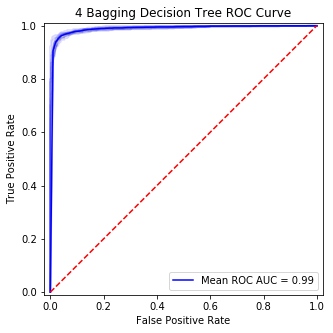

Accuracy:   0.9602993140719185
AUC:   0.9870425399382043


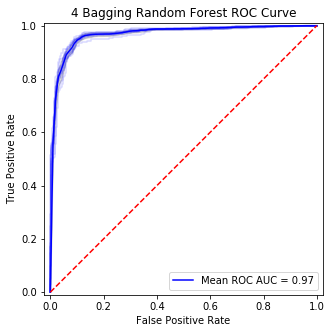

Accuracy:   0.9135314903346498
AUC:   0.9673100442862659


In [14]:
# Run Bagging DT
def run_bagging_DT(feauteSet, printRoc, runName):
    bagClf = BaggingClassifier(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2, max_depth=10),
                              n_estimators=500)

    
    acc, mean_auc = testClassifer(bagClf, x, y, printRoc, runName, feauteSet)
    return pd.Series([runName, feauteSet, acc, mean_auc], 
                      index=['Algorithm','FeatureSet','TestAcc','TestAUC'])

# Run Bagging RF
def run_bagging_RF(feauteSet, printRoc, runName):
    bagClf = BaggingClassifier(RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=1, n_estimators=1000),
                               n_estimators=50)
    
    acc, mean_auc = testClassifer(bagClf, x, y, printRoc, runName, feauteSet)
    return pd.Series([runName, feauteSet, acc, mean_auc], 
                      index=['Algorithm','FeatureSet','TestAcc','TestAUC'])

ResultsCollection = ResultsCollection.append(run_bagging_DT(4, True, 'Bagging Decision Tree'), ignore_index=True)
ResultsCollection = ResultsCollection.append(run_bagging_RF(4, True, 'Bagging Random Forest'), ignore_index=True)

### Boosting

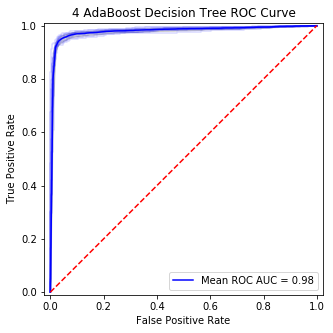

Accuracy:   0.9537518187487009
AUC:   0.978331488846823


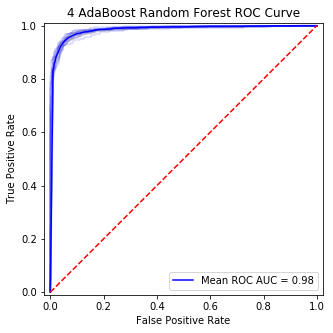

Accuracy:   0.9439825400124714
AUC:   0.9827295134967662


In [16]:
def run_ada_DT(feauteSet, printRoc, runName):
    bagClf = AdaBoostClassifier(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2, max_depth=10))

    acc, mean_auc = testClassifer(bagClf, x, y, printRoc, runName, feauteSet)
    return pd.Series([runName, feauteSet, acc, mean_auc], 
                      index=['Algorithm','FeatureSet','TestAcc','TestAUC'])

def run_ada_RF(feauteSet, printRoc, runName):
    bagClf = AdaBoostClassifier(RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=1, n_estimators=1000))

    acc, mean_auc = testClassifer(bagClf, x, y, printRoc, runName, feauteSet)
    return pd.Series([runName, feauteSet, acc, mean_auc], 
                      index=['Algorithm','FeatureSet','TestAcc','TestAUC'])

ResultsCollection = ResultsCollection.append(run_ada_DT(4, True, 'AdaBoost Decision Tree'), ignore_index=True)   
ResultsCollection = ResultsCollection.append(run_ada_RF(4, True, 'AdaBoost Random Forest'), ignore_index=True)   

### Gradient Boosting Classifier

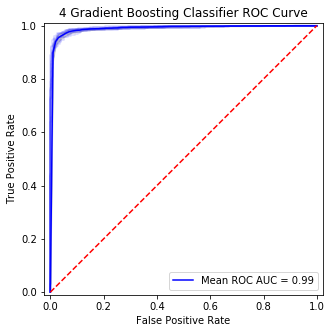

Accuracy:   0.9623778840157972
AUC:   0.9876687222069486


In [17]:
def run_grad(feauteSet, printRoc, runName):
    bagClf = GradientBoostingClassifier(learning_rate=0.03, max_depth=5, min_samples_leaf=40, n_estimators=500)

    acc, mean_auc = testClassifer(bagClf, x, y, printRoc, runName, feauteSet)
    return pd.Series([runName, feauteSet, acc, mean_auc], 
                      index=['Algorithm','FeatureSet','TestAcc','TestAUC'])

ResultsCollection = ResultsCollection.append(run_grad(4, True, 'Gradient Boosting Classifier'), ignore_index=True)   

### Voting

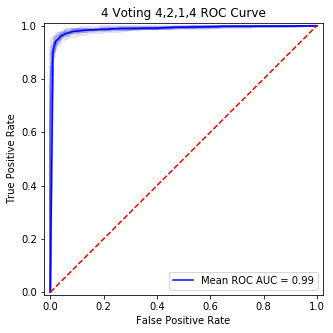

Accuracy:   0.9615464560382457
AUC:   0.9854993032990488


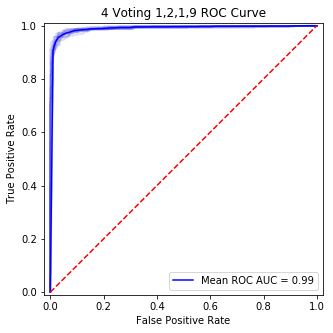

Accuracy:   0.9621700270214093
AUC:   0.9873676623161188


In [18]:
def run_voting(feauteSet, printRoc, runName, myWeight):
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2, max_depth=10)
    rf = RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=1, n_estimators=1000)
    lr = LogisticRegression(random_state=10, solver='lbfgs',multi_class='multinomial', C=0.00001)
    sv = svm.SVC(gamma='auto', probability=True)
    grd = GradientBoostingClassifier(learning_rate=0.03, max_depth=5, min_samples_leaf=40, n_estimators=500)

    voter = VotingClassifier(estimators=[('lr', lr), ('rf', rf), ('dt', dt), ('grd', grd)], voting='soft', weights=myWeight)

    acc, mean_auc = testClassifer(voter, x, y, printRoc, runName, feauteSet)
    return pd.Series([runName, feauteSet, acc, mean_auc], 
                      index=['Algorithm','FeatureSet','TestAcc','TestAUC'])

ResultsCollection = ResultsCollection.append(run_voting(4, True, 'Voting 4,2,1,4', [4,2,1,4]), ignore_index=True)   
ResultsCollection = ResultsCollection.append(run_voting(4, True, 'Voting 1,2,1,9', [1,2,1,9]), ignore_index=True)  

In [19]:
print(ResultsCollection.sort_values('TestAcc'))

                       Algorithm FeatureSet   TestAcc   TestAUC
0                    Naive Bayes          4  0.546352  0.559616
1            Logistic Regression          4  0.874039  0.936736
6          Bagging Random Forest          4  0.913531  0.967310
4                  Random Forest          4  0.913635  0.966426
2                            SVM          4  0.915298  0.950612
8         AdaBoost Random Forest          4  0.943983  0.982730
3                  Decision Tree          4  0.951050  0.969583
7         AdaBoost Decision Tree          4  0.953752  0.978331
5          Bagging Decision Tree          4  0.960299  0.987043
10                Voting 4,2,1,4          4  0.961546  0.985499
11                Voting 1,2,1,9          4  0.962170  0.987368
9   Gradient Boosting Classifier          4  0.962378  0.987669


In [20]:
outPutFileName = path + 'Results.csv'
ResultsCollection.sort_values('TestAcc').to_csv(outPutFileName, encoding='utf-8')